## Libraries

In [2]:
%matplotlib inline

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

pd.set_option("display.max_columns", 144)

## Data Description

Useful tool

* https://translate.google.cn/
* https://www.tablesgenerator.com/markdown_tables

| Column 	| Description 	| Translation 	|
|:--	|:--	|:--	|
| `surface_area` 	| The total area in square kilometers 	| 总面积，平方公里 	|
| `agricultural_land` 	| The agricultural land of the total area in square kilometers 	| 总农业用地面积，平方公里 	|
| `forest_area` 	| The forest area in the total area in square kilometers 	| 总森林用地面积，平方公理 	|
| `armed_forces_total` 	| The count of armed forces paid by this geographical area 	| 区域的武装部队人数（治安力量？） 	|
| `urban_pop_major_cities` 	| The percent of the total population dwelling in major cities 	| 主要城市居住人口占总人口的百分比 	|
| `urban_pop_minor_cities` 	| The percent of the total population dwelling in minor cities 	| 居住在小城市的总人口百分比 	|
| `national_income` 	| National Income as an ordinal categorical variable 	| 国民收入（分类变量） 	|
| `inflation_annual` 	| Yearly Inflation Rate 	| 年通胀率 	|
| `inflation_monthly` 	| Average Monthly Inflation Rate = annual inflation/12 	| 月通胀率 	|
| `inflation_weekly` 	| Average Weekly Inflation Rate = annual inflation/52 	| 周通胀率 	|
| `mobile_subscriptions` 	| Describes the number of mobile subscriptions per person 	| 手机注册率 	|
| `internet_users` 	| The average number of people using the internet in a range of 100 or 1000 people 	| 网络用户（不同单位） 	|
| `secure_internet_servers_total` 	| The actual number of secure internet servers in the area 	| 安全网络数量 	|
| `improved_sanitation` 	| The known access of the population to improved sanitation facilities 	| 人口获得改善的卫生设施机会 	|
| `women_parliament_seats_rate ` 	| Describes the percent range of parliament seats occupied by women 	| 女性议会席位百分比 	|
| `life_expectancy` 	| Years of life an average person is expected to live in this area (target variable). 	| 目标值：预期年龄 	|

**note1: agricultural and forest land may be converted to retio rate, a cooralation may be necessary**

**note2: inflation rate in different unit may convert to annual value**

## Data Acquisition

In [3]:
# load file, index_col set
# if missing values are not standard, us missing_value=['n/a','na','--'],na_values=missing_values when load csv
df = pd.read_csv('train.csv',index_col=0)

In [4]:
# show head of file
df.head()

,surface_area,agricultural_land,forest_area,armed_forces_total,urban_pop_major_cities,urban_pop_minor_cities,national_income,inflation_annual,inflation_monthly,inflation_weekly,mobile_subscriptions,internet_users,secure_internet_servers_total,improved_sanitation,women_parliament_seats_rate,life_expectancy
0,120540.0,2.632839e+06,5.417843e+06,1379000.0,55.747169,4.688831,unknown,NaN,NaN,NaN,less than 1 per person,0 per 1000 people,NaN,high access,[0%-25%),69.494195
1,752610.0,2.403039e+07,4.957554e+07,16500.0,16.890687,23.136313,very low,NaN,0.581473,NaN,less than 1 per person,154 per 1000 people,2.623624e+06,low access,[0%-25%),59.237366
2,1396.0,3.000000e+03,8.000000e+01,NaN,18.390090,23.139910,unknown,NaN,NaN,NaN,more than 1 per person,90 per 100 people,1.656589e+09,no info,unknown,81.300000
3,2758812.0,1.228845e+08,1.050943e+08,1518650.0,50.966885,24.522427,high,1.374906,NaN,NaN,more than 1 per person,76 per 100 people,6.625072e+08,very high access,[25%-50%),81.373197
4,340.0,1.100000e+04,1.699000e+04,NaN,5.311885,30.271115,unknown,-0.044229,NaN,NaN,more than 1 per person,350 per 1000 people,2.832808e+07,very high access,[25%-50%),73.193561


In [5]:
# shape of table
df.shape

(362, 16)

In [6]:
# data dype
# may change dtype when loading file if file is huge, for example dtype={'carat': np.float64}
df.dtypes

surface_area                     float64
agricultural_land                float64
forest_area                      float64
armed_forces_total               float64
urban_pop_major_cities           float64
urban_pop_minor_cities           float64
national_income                   object
inflation_annual                 float64
inflation_monthly                float64
inflation_weekly                 float64
mobile_subscriptions              object
internet_users                    object
secure_internet_servers_total    float64
improved_sanitation               object
women_parliament_seats_rate       object
life_expectancy                  float64
dtype: object

In [7]:
df.isnull().sum()

surface_area                       0
agricultural_land                  4
forest_area                        5
armed_forces_total                44
urban_pop_major_cities             2
urban_pop_minor_cities             2
national_income                    0
inflation_annual                 216
inflation_monthly                206
inflation_weekly                 342
mobile_subscriptions               0
internet_users                     0
secure_internet_servers_total     10
improved_sanitation                0
women_parliament_seats_rate        0
life_expectancy                    0
dtype: int64

**note: inflation rate missing values are qiute large, but they may convert to each, let convert to annual inflation value first**

In [8]:
# make a copy
df1 = df.copy()

In [9]:
# if annual value is missing, fill from monthly, or weekly data
for i in df1.index:
    if np.isnan(df1.loc[i, 'inflation_annual']):
        if np.isnan(df1.loc[i, 'inflation_monthly']):
            df1.loc[i, 'inflation_annual'] = 52 * df1.loc[i, 'inflation_weekly']
        else:
            df1.loc[i, 'inflation_annual'] = 12 * df1.loc[i, 'inflation_monthly']
            
# Remove columns 'inflation_monthly' & 'inflation_weekly'
df1.drop(['inflation_monthly', 'inflation_weekly'], axis=1, inplace=True)

In [10]:
df1.isnull().sum()

surface_area                      0
agricultural_land                 4
forest_area                       5
armed_forces_total               44
urban_pop_major_cities            2
urban_pop_minor_cities            2
national_income                   0
inflation_annual                 40
mobile_subscriptions              0
internet_users                    0
secure_internet_servers_total    10
improved_sanitation               0
women_parliament_seats_rate       0
life_expectancy                   0
dtype: int64

**note: agriculture and forest land can be replaced by ratio**

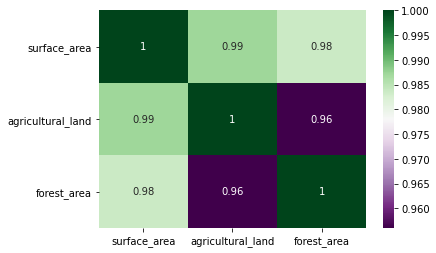

In [11]:
# Check if these three variables are highly correlated (multicollinearity problem)
sns.heatmap(df1[['surface_area', 'agricultural_land','forest_area']].corr(), cmap='PRGn', annot=True);

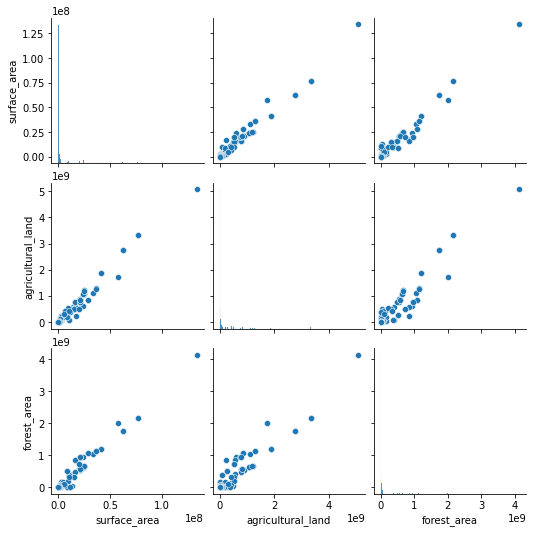

In [12]:
# Plot pairwise relationship and distribution of these three variables
sns.pairplot(df1[['surface_area', 'agricultural_land','forest_area']]);

**Note1: Strong linear relationship, it is said no use for model training, it may be converted to ratio value, which are more meaningful, actually, I think so, either.**
**Note2: the surface_area seems have unit problems, 1e8 magnitute is smaller than argriculture and forest, guessing that the surface area unit is wrong, **

In [13]:
# make a copy of the orginal dataframe
df2 = df1.copy()

# Step 1: Multiply 'surface_area' by 100
df2['surface_area'] = df2['surface_area'] * 100

# Step 2: Creates new variables 
df2['agricultural_portion'] = df2['agricultural_land'] / df2['surface_area'] 
df2['forest_portion'] = df2['forest_area'] / df2['surface_area']

# Step 3: Remove 'agricultural_land' and 'forest_area' colums from dataset
df2.drop(['agricultural_land', 'forest_area'], axis=1, inplace=True)

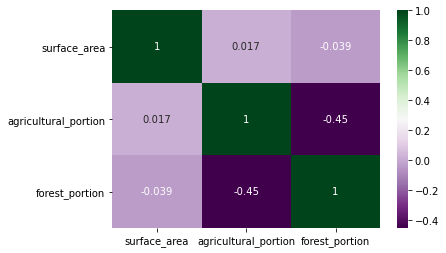

In [14]:
# Check correlations among 'surface_area', 'agriculture_portion' & 'forest_portion' for multicollinearity
sns.heatmap(df2[['surface_area', 'agricultural_portion','forest_portion']].corr(), cmap='PRGn',annot=True);

In [15]:
df2.isnull().sum()

surface_area                      0
armed_forces_total               44
urban_pop_major_cities            2
urban_pop_minor_cities            2
national_income                   0
inflation_annual                 40
mobile_subscriptions              0
internet_users                    0
secure_internet_servers_total    10
improved_sanitation               0
women_parliament_seats_rate       0
life_expectancy                   0
agricultural_portion              4
forest_portion                    5
dtype: int64

In [16]:
df2.dtypes

surface_area                     float64
armed_forces_total               float64
urban_pop_major_cities           float64
urban_pop_minor_cities           float64
national_income                   object
inflation_annual                 float64
mobile_subscriptions              object
internet_users                    object
secure_internet_servers_total    float64
improved_sanitation               object
women_parliament_seats_rate       object
life_expectancy                  float64
agricultural_portion             float64
forest_portion                   float64
dtype: object

**note: convert: national_income, mobile_subscriptions, internet_users, improved_sanitation, women_parliament_seats_rate**

In [17]:
df2.head()

,surface_area,armed_forces_total,urban_pop_major_cities,urban_pop_minor_cities,national_income,inflation_annual,mobile_subscriptions,internet_users,secure_internet_servers_total,improved_sanitation,women_parliament_seats_rate,life_expectancy,agricultural_portion,forest_portion
0,12054000.0,1379000.0,55.747169,4.688831,unknown,NaN,less than 1 per person,0 per 1000 people,NaN,high access,[0%-25%),69.494195,0.218420,0.449464
1,75261000.0,16500.0,16.890687,23.136313,very low,6.977676,less than 1 per person,154 per 1000 people,2.623624e+06,low access,[0%-25%),59.237366,0.319294,0.658715
2,139600.0,NaN,18.390090,23.139910,unknown,NaN,more than 1 per person,90 per 100 people,1.656589e+09,no info,unknown,81.300000,0.021490,0.000573
3,275881200.0,1518650.0,50.966885,24.522427,high,1.374906,more than 1 per person,76 per 100 people,6.625072e+08,very high access,[25%-50%),81.373197,0.445426,0.380940
4,34000.0,NaN,5.311885,30.271115,unknown,-0.044229,more than 1 per person,350 per 1000 people,2.832808e+07,very high access,[25%-50%),73.193561,0.323529,0.499706


In [18]:
# Convert categorical and ordinal fearures into numeric features
# Decide which categorical variables you want to use in model
for col_name in df2.columns:
    if df2[col_name].dtypes == 'object':
        unique_cat = len(df2[col_name].unique())
        print("Feature '{col_name}' has {unique_cat} unique categories".format(col_name=col_name, unique_cat=unique_cat))

Feature 'national_income' has 7 unique categories
Feature 'mobile_subscriptions' has 5 unique categories
Feature 'internet_users' has 198 unique categories
Feature 'improved_sanitation' has 6 unique categories
Feature 'women_parliament_seats_rate' has 4 unique categories


In [19]:
# begin from the most one internet_users
# Convert 'internet_users' column to associated percentages
variable_split = df2['internet_users'].str.split()
df2['percent_internet_users'] = (pd.to_numeric(variable_split.str.get(0), errors='coerce') / 
                          pd.to_numeric(variable_split.str.get(2), errors='coerce'))
# Remove 'internet_users' column
df2.drop('internet_users', axis=1, inplace=True)

In [20]:
df2.head()

,surface_area,armed_forces_total,urban_pop_major_cities,urban_pop_minor_cities,national_income,inflation_annual,mobile_subscriptions,secure_internet_servers_total,improved_sanitation,women_parliament_seats_rate,life_expectancy,agricultural_portion,forest_portion,percent_internet_users
0,12054000.0,1379000.0,55.747169,4.688831,unknown,NaN,less than 1 per person,NaN,high access,[0%-25%),69.494195,0.218420,0.449464,0.000
1,75261000.0,16500.0,16.890687,23.136313,very low,6.977676,less than 1 per person,2.623624e+06,low access,[0%-25%),59.237366,0.319294,0.658715,0.154
2,139600.0,NaN,18.390090,23.139910,unknown,NaN,more than 1 per person,1.656589e+09,no info,unknown,81.300000,0.021490,0.000573,0.900
3,275881200.0,1518650.0,50.966885,24.522427,high,1.374906,more than 1 per person,6.625072e+08,very high access,[25%-50%),81.373197,0.445426,0.380940,0.760
4,34000.0,NaN,5.311885,30.271115,unknown,-0.044229,more than 1 per person,2.832808e+07,very high access,[25%-50%),73.193561,0.323529,0.499706,0.350


In [21]:
# Check the frequency of categories (labels) in each categorical variable 
for name in df2.select_dtypes(include=['object']):
    print(name,':')
    print(df2[name].value_counts(),'\n')

national_income :
low            81
very low       77
medium low     76
unknown        48
high           37
medium high    31
very high      12
Name: national_income, dtype: int64 

mobile_subscriptions :
more than 1 per person    188
less than 1 per person    164
unknown                     7
more than 2 per person      2
more than 3 per person      1
Name: mobile_subscriptions, dtype: int64 

improved_sanitation :
very high access    155
low access           55
medium access        54
high access          47
very low access      33
no info              18
Name: improved_sanitation, dtype: int64 

women_parliament_seats_rate :
[0%-25%)     249
[25%-50%)     82
unknown       30
[50%-75%)      1
Name: women_parliament_seats_rate, dtype: int64 



In [22]:
# Assign "mobile_subscriptions" values to 1 if mobile subscriptions is
# less than 1 per person, otherwise 2:
df2['mobile_subscriptions'] = [1 if x == 'less than 1 per person' else 2 for x in df2['mobile_subscriptions']]

In [23]:
# Assign "women_parliament_seats_rate" to 1 if women _parliament seat _rate is
# [0%-25%), 2 if it is [25%-75%), or 3 if unknown:

df2['women_parliament_seats_rate'] = (
    df2['women_parliament_seats_rate'].replace('[0%-25%)', 1))
df2['women_parliament_seats_rate'] = (
    df2['women_parliament_seats_rate'].replace('[25%-50%)', 2))
df2['women_parliament_seats_rate'] = (
    df2['women_parliament_seats_rate'].replace('[50%-75%)', 2))
df2['women_parliament_seats_rate'] = (
    df2['women_parliament_seats_rate'].replace('unknown', 3))

In [24]:
# Assign numeric values to the levels of "national_income" (ordinal variable):
mapper_1 = {'very low': 1, 'medium low': 2, 'low': 3,
            'medium high': 4, 'high': 5, 'very high': 6,
            'unknown': 7}
df2['national_income'].replace(mapper_1, inplace=True)

In [25]:
# Assign numeric values to the levels of "improved_sanitation" (Ordinal Variable):
mapper_2 = {'very low access': 1, 'low access': 2, 'medium access': 3,
            'high access': 4, 'very high access': 5, 'no info': 6}
df2['improved_sanitation'].replace(mapper_2, inplace=True)

In [26]:
df2.head()

,surface_area,armed_forces_total,urban_pop_major_cities,urban_pop_minor_cities,national_income,inflation_annual,mobile_subscriptions,secure_internet_servers_total,improved_sanitation,women_parliament_seats_rate,life_expectancy,agricultural_portion,forest_portion,percent_internet_users
0,12054000.0,1379000.0,55.747169,4.688831,7,NaN,1,NaN,4,1,69.494195,0.218420,0.449464,0.000
1,75261000.0,16500.0,16.890687,23.136313,1,6.977676,1,2.623624e+06,2,1,59.237366,0.319294,0.658715,0.154
2,139600.0,NaN,18.390090,23.139910,7,NaN,2,1.656589e+09,6,3,81.300000,0.021490,0.000573,0.900
3,275881200.0,1518650.0,50.966885,24.522427,5,1.374906,2,6.625072e+08,5,2,81.373197,0.445426,0.380940,0.760
4,34000.0,NaN,5.311885,30.271115,7,-0.044229,2,2.832808e+07,5,2,73.193561,0.323529,0.499706,0.350


## Data missing filling

In [27]:
# make a copy of df1  
df3 = df2.copy()
# How much of your data is missing?
df3.isnull().sum().sort_values(ascending=False)

armed_forces_total               44
inflation_annual                 40
secure_internet_servers_total    10
percent_internet_users            6
forest_portion                    5
agricultural_portion              4
urban_pop_major_cities            2
urban_pop_minor_cities            2
surface_area                      0
national_income                   0
mobile_subscriptions              0
improved_sanitation               0
women_parliament_seats_rate       0
life_expectancy                   0
dtype: int64

In [31]:
# Impute missing values using Imputer in sklearn.preprocessing

imp = SimpleImputer(missing_values=np.nan, strategy='median')
imp.fit(df3)
df3 = pd.DataFrame(data=imp.transform(df3) , columns=df3.columns)

In [32]:
df3.head(10)

,surface_area,armed_forces_total,urban_pop_major_cities,urban_pop_minor_cities,national_income,inflation_annual,mobile_subscriptions,secure_internet_servers_total,improved_sanitation,women_parliament_seats_rate,life_expectancy,agricultural_portion,forest_portion,percent_internet_users
0,1.205400e+07,1379000.0,55.747169,4.688831,7.0,3.371067,1.0,2.671228e+07,4.0,1.0,69.494195,0.218420,0.449464,0.000
1,7.526100e+07,16500.0,16.890687,23.136313,1.0,6.977676,1.0,2.623624e+06,2.0,1.0,59.237366,0.319294,0.658715,0.154
2,1.396000e+05,53525.0,18.390090,23.139910,7.0,3.371067,2.0,1.656589e+09,6.0,3.0,81.300000,0.021490,0.000573,0.900
3,2.758812e+08,1518650.0,50.966885,24.522427,5.0,1.374906,2.0,6.625072e+08,5.0,2.0,81.373197,0.445426,0.380940,0.760
4,3.400000e+04,53525.0,5.311885,30.271115,7.0,-0.044229,2.0,2.832808e+07,5.0,2.0,73.193561,0.323529,0.499706,0.350
5,7.835600e+07,612800.0,37.699524,34.134476,2.0,8.891570,1.0,1.166004e+08,5.0,1.0,74.862439,0.499032,0.148224,0.450
6,2.846040e+09,5032780.0,32.853558,37.469387,4.0,2.773339,2.0,4.702241e+08,5.0,1.0,76.569368,0.294847,0.379839,0.640
7,5.490910e+07,325600.0,24.582761,54.237239,5.0,1.955685,1.0,4.093085e+08,5.0,2.0,81.968293,0.526820,0.304076,0.810
8,3.571700e+07,186450.0,18.091168,56.596832,5.0,2.008491,2.0,1.110775e+09,5.0,2.0,80.892683,0.478109,0.327452,0.820
9,7.160000e+04,147600.0,51.288344,48.711656,7.0,4.528651,2.0,6.353061e+08,5.0,1.0,81.995122,0.010340,0.231586,0.720


## Visualization, Modeling, Machine Learning

 Can you construct a reliable model that predicts the life expectancy of an area (country, region, group of countries) using socioeconomic variables and identify how different features influence their decision? 
 
 Please explain your findings effectively to technical and non-technical audiences using comments and visualizations, if appropriate.
- **Build an optimized model that effectively solves the business problem.**
- **The model would be evaluated on the basis of Mean Absolute Error.**
- **Read the Test.csv file and prepare features for testing.**

In [33]:
def plot_histogram(x):
    plt.hist(x, color='gray', edgecolor='black', alpha=0.8)
    plt.title("Histogram of '{var_name}'".format(var_name=x.name))
    plt.xlabel("Value")
    plt.ylabel("Frequency")
    plt.show()

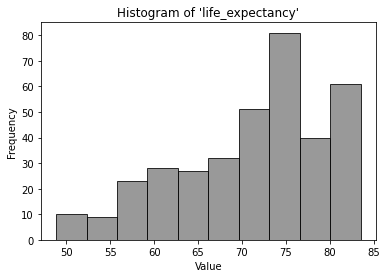

In [34]:
# Plot distribution of traget (outcome) variable in the training data
plot_histogram(df3['life_expectancy'])

In [35]:
#Loading Test data
test_data=pd.read_csv('test.csv',index_col=0)
test_data.head()

,surface_area,agricultural_land,forest_area,armed_forces_total,urban_pop_major_cities,urban_pop_minor_cities,national_income,inflation_annual,inflation_monthly,inflation_weekly,mobile_subscriptions,internet_users,secure_internet_servers_total,improved_sanitation,women_parliament_seats_rate
9,322460.0,2.088892e+07,1.054769e+07,NaN,0.846584,51.919416,low,2.569961,NaN,NaN,less than 1 per person,84 per 1000 people,1849926.0,very low access,[0%-25%)
16,513120.0,2.220651e+07,1.641032e+07,453550.0,42.139810,5.803190,low,2.184886,NaN,NaN,more than 1 per person,289 per 1000 people,17983312.0,very high access,[0%-25%)
19,18580.0,1.872230e+05,8.527691e+05,NaN,1.699056,67.396944,unknown,NaN,NaN,NaN,less than 1 per person,66 per 100 people,240458015.0,very high access,unknown
23,112490.0,3.252347e+06,4.857911e+06,20000.0,48.602426,4.934574,low,NaN,0.430158,NaN,less than 1 per person,178 per 1000 people,9427882.0,high access,[0%-25%)
28,783560.0,3.911844e+07,1.171853e+07,612800.0,43.734006,28.635994,medium low,NaN,0.624424,NaN,less than 1 per person,46 per 100 people,50379814.0,very high access,[0%-25%)


In [37]:
# Create a copy of test dataframe
tdf = test_data.copy()

# Step 1: Multiply 'surface_area' by 100
tdf['surface_area'] = tdf['surface_area'] * 100

# Step 2: Creates new variables 
tdf['agricultural_portion'] = tdf['agricultural_land'] / tdf['surface_area'] 
tdf['forest_portion'] = tdf['forest_area'] / tdf['surface_area']

# Step 3: Remove 'agricultural_land' and 'forest_area' colums from dataset
tdf.drop(['agricultural_land', 'forest_area'], axis=1, inplace=True)

# Step 4: Replace missing values in column 'inflation_annual' with information from
# columns 'inflation_monthly' & 'inflation_weekly'

for i in tdf.index:
    if np.isnan(tdf.loc[i, 'inflation_annual']):
        if np.isnan(tdf.loc[i, 'inflation_monthly']):
            tdf.loc[i, 'inflation_annual'] = 52 * tdf.loc[i, 'inflation_weekly']
        else:
            tdf.loc[i, 'inflation_annual'] = 12 * tdf.loc[i, 'inflation_monthly']

# Step5: Remove columns 'inflation_monthly' & 'inflation_weekly'
tdf.drop(['inflation_monthly', 'inflation_weekly'], axis=1, inplace=True)

# Step6: Convert 'internet_users' column to associated percentages
variable_split = tdf['internet_users'].str.split()
tdf['percent_internet_users'] = (pd.to_numeric(variable_split.str.get(0), errors='coerce') / 
                          pd.to_numeric(variable_split.str.get(2), errors='coerce'))

# Step 7: Remove 'internet_users' column
tdf.drop('internet_users', axis=1, inplace=True)

# Step 8: Assign "mobile_subscriptions" values to 1 if mobile subscriptions is
# less than 1 per person, otherwise 2:
tdf['mobile_subscriptions'] = [1 if x == 'less than 1 per person' else 2 for x in tdf['mobile_subscriptions']]

# Step 9: Assign "women_parliament_seats_rate" to 1 if women _parliament seat _rate is
# [0%-25%), 2 if it is [25%-75%), or 3 if unknown:

tdf['women_parliament_seats_rate'] = (
    tdf['women_parliament_seats_rate'].replace('[0%-25%)', 1))
tdf['women_parliament_seats_rate'] = (
    tdf['women_parliament_seats_rate'].replace('[25%-50%)', 2))
tdf['women_parliament_seats_rate'] = (
    tdf['women_parliament_seats_rate'].replace('[50%-75%)', 2))
tdf['women_parliament_seats_rate'] = (
    tdf['women_parliament_seats_rate'].replace('unknown', 3))

# Step 10: Assign numeric values to the levels of "national_income" (ordinal variable):
mapper_1 = {'very low': 1, 'medium low': 2, 'low': 3,
            'medium high': 4, 'high': 5, 'very high': 6,
            'unknown': 7}
tdf['national_income'].replace(mapper_1, inplace=True)

# Step 11: Assign numeric values to the levels of "improved_sanitation" (Ordinal Variable):
mapper_2 = {'very low access': 1, 'low access': 2, 'medium access': 3,
            'high access': 4, 'very high access': 5, 'no info': 6}
tdf['improved_sanitation'].replace(mapper_2, inplace=True)

# Step12: Impute missing values using Imputer in sklearn.preprocessing
imp = SimpleImputer(missing_values=np.nan, strategy='median')
imp.fit(tdf)
tdf = pd.DataFrame(data=imp.transform(tdf) , columns=tdf.columns)

# Show the first 5 rows of tdf
tdf.head()

,surface_area,armed_forces_total,urban_pop_major_cities,urban_pop_minor_cities,national_income,inflation_annual,mobile_subscriptions,secure_internet_servers_total,improved_sanitation,women_parliament_seats_rate,agricultural_portion,forest_portion,percent_internet_users
0,32246000.0,50800.0,0.846584,51.919416,3.0,2.569961,1.0,1849926.0,1.0,1.0,0.647799,0.327101,0.084
1,51312000.0,453550.0,42.139810,5.803190,3.0,2.184886,2.0,17983312.0,5.0,1.0,0.432774,0.319814,0.289
2,1858000.0,50800.0,1.699056,67.396944,7.0,3.009844,1.0,240458015.0,5.0,3.0,0.100766,0.458972,0.660
3,11249000.0,20000.0,48.602426,4.934574,3.0,5.161899,1.0,9427882.0,4.0,1.0,0.289123,0.431853,0.178
4,78356000.0,612800.0,43.734006,28.635994,2.0,7.493090,1.0,50379814.0,5.0,1.0,0.499240,0.149555,0.460


## Random Forest Regression

In [38]:
# Create outcome and input DataFrames
y = df3['life_expectancy'] 
X = df3.drop('life_expectancy', axis=1)
y.head()

0    69.494195
1    59.237366
2    81.300000
3    81.373197
4    73.193561
Name: life_expectancy, dtype: float64

In [39]:
# Create train and validation datasets to build the Random Forest (RF) regression 
# model and find the best set of the model parameters 

#X_train, X_validation, y_train, y_validation= train_test_split(X, y,
#                                                   random_state = 0)

In [40]:
# Use 'Grid Search' to find the best set of RF regression parameters 
# using full dataset with criterion = 'mean absolute error' (mae) and 
# random_state = 33

n_estimators = [50, 100, 150, 200]
max_features = [4, 8, 13]
max_depth = [5, 6, 7]
min_split = [2, 3, 4] 
min_leaf = [1, 2, 3]
best_score = 100

for n in n_estimators:
    for f in max_features:
        for d in max_depth:
            for s in min_split:   
                for l in min_leaf:
                    rf = RandomForestRegressor(
                     n_estimators = n, 
                     criterion = 'mae', 
                     max_features= f,
                     random_state = 33, 
                     oob_score = False,
                     max_depth = d, 
                     min_samples_split = s, 
                     min_samples_leaf = l)
                    rf.fit (X, y)    
                    y_model = rf.predict(X)
                    #score = mean_absolute_error(y, y_model)
                    score = - np.mean(cross_val_score(rf, X, y, cv=4, scoring = 'neg_mean_absolute_error'))
                    if score <= best_score:
                        best_score = score
                        max_n = n
                        max_f = f
                        max_d = d
                        max_s = s
                        max_l = l


print ("Number of Estimators:", max_n)               
print ("Max features:", max_f)
print ("Max Depth:", max_d)
print ("Min Split:", max_s)
print ("Min Leaf:", max_l)
print("Best Mean Absolute Error: {:.3f}".format(best_score))

Number of Estimators: 50
Max features: 8
Max Depth: 7
Min Split: 2
Min Leaf: 1
Best Mean Absolute Error: 2.540


In [41]:
print(best_score)

2.539969056127632


In [42]:
from sklearn.model_selection import GridSearchCV
parameters = {'max_depth' : (5, 6, 7)
              ,'max_features' : (4, 8, 13)
              ,'min_samples_leaf' : (1, 2, 3)
              ,'min_samples_split' : (2, 3, 4)
              ,'n_estimators' : (50, 100, 150, 200)}
rf1 = GridSearchCV(RandomForestRegressor(
                     criterion = 'mae', 
                     random_state = 33, 
                     oob_score = False),
                   param_grid = parameters,
                   cv =4,
                   verbose = True)

In [43]:
rf1_model = rf1.fit(X, y)

Fitting 4 folds for each of 324 candidates, totalling 1296 fits


In [44]:
rf1_model.best_estimator_

RandomForestRegressor(criterion='mae', max_depth=7, max_features=8,
                      random_state=33)

In [45]:
rf1_model.best_score_

0.796719447875297

In [46]:
rf1_model.best_params_

{'max_depth': 7,
 'max_features': 8,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 100}

In [47]:
# clearly, this one is no better than the former one.
# Fit a RF using best indentified parameters
rf = RandomForestRegressor(criterion = 'mae'
                           , random_state = 33
                           , max_depth=7
                           , max_features=8
                           , min_samples_leaf=1
                           , min_samples_split=2
                           , n_estimators=100)

rf.fit(X, y)

RandomForestRegressor(criterion='mae', max_depth=7, max_features=8,
                      random_state=33)

In [48]:
# Pridict test instances using test dataframe (tdf)
y_test = rf.predict(tdf)
y_test

array([60.95521233, 72.36269538, 77.45200135, 70.13986823, 73.99480565,
       68.26092015, 74.54507497, 67.81746819, 72.481391  , 72.78530662,
       76.94771665, 79.72520294, 60.22303955, 59.41762307, 81.66312683,
       74.69370193, 74.7550796 , 75.3089078 , 76.1614448 , 63.49115377,
       63.53540934, 73.66034761, 73.89014027, 77.52634352, 74.0564855 ,
       71.38978557, 57.66910175, 81.39429166, 81.05823576, 79.12222845,
       74.35877357, 62.31669605, 59.50176472, 61.6589037 , 81.19614774,
       80.04004682, 77.10195095, 79.93701169, 76.06789444, 80.50504461,
       74.13551638, 66.78384151, 61.43097222, 62.06891153, 58.18963117,
       76.87484093, 69.22435151, 64.99861032, 57.93074281, 77.49838138,
       75.08354729, 74.14849801, 65.49952048, 81.06219156, 58.04906738,
       78.33744481, 80.90431656, 60.75851408, 72.92321286, 66.2752132 ,
       70.87486608, 73.23645265, 56.55765396, 71.51642979, 72.18304175,
       60.48683895, 62.77551482, 58.84844905, 74.35817498, 66.23

In [49]:
print(f'Test : {rf1_model.score(tdf, y_test):.3f}')
print(f'Train : {rf1_model.score(X, y):.3f}')

Test : 1.000
Train : 0.944


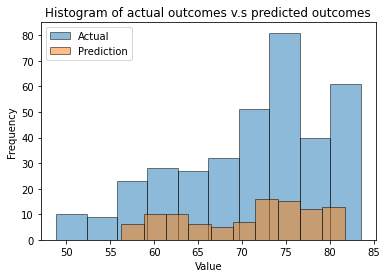

In [50]:
# Plot histograms to compare distribution of actual outcomes vs. prediction 
def plot_histogram_comp(x,y):
    plt.hist(x, alpha=0.5, edgecolor='black', label='Actual')
    plt.hist(y, alpha=0.5, edgecolor='black', label='Prediction')
    plt.title("Histogram of actual outcomes v.s predicted outcomes")
    plt.xlabel("Value")
    plt.ylabel("Frequency")
    plt.legend(loc='upper left')
    plt.show()
# Check to see if distribution of actual target values is close to the distribution
# of predicted target values
plot_histogram_comp(y,y_test)



**The government wants to know what are the most important features for your model.  Can you tell them?**

> #### Task:
- **Visualize the top 13 features and their feature importance.**




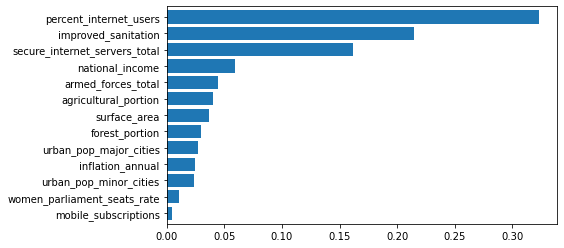

In [51]:
# Extract feature importance determined by RF model
feature_imp = pd.Series(rf.feature_importances_, index=X.columns)
feature_imp.sort_values(ascending=True, inplace=True)

# Creating a bar plot
feature_imp.plot(kind='barh', width=0.8, figsize=(7,4));

> #### Task:
- **Submit the predictions on the test dataset using your optimized model** <br/>
    For each record in the test set (`Test.csv`), you must predict the value of the `life_expectancy` variable. You should submit a CSV file with a header row and one row per test entry. The file (submissions.csv) should have exactly 2 columns:

The file (`submissions.csv`) should have exactly 2 columns:
   - **id**
   - **life_expectancy**

In [52]:
# Create a submission_df
d = {'id': test_data.index, 'life_expectancy': y_test}
submission_df = pd.DataFrame(data=d)
submission_df

,id,life_expectancy
0,9,60.955212
1,16,72.362695
2,19,77.452001
3,23,70.139868
4,28,73.994806
...,...,...
95,433,56.254268
96,441,77.127361
97,443,71.208266
98,453,68.558294


In [53]:
#Submission
submission_df.to_csv('submissions.csv',index=False)

## Grid Searching Random Forest

In [54]:
X_train, X_test, Y_train, Y_test= train_test_split(X, y,test_size=0.25, random_state = 42)

In [55]:
print('Training Features Shape:', X_train.shape)
print('Training Target Shape:', Y_train.shape)
print('Testing Features Shape:', X_test.shape)
print('Testing Target Shape:', Y_test.shape)

Training Features Shape: (271, 13)
Training Target Shape: (271,)
Testing Features Shape: (91, 13)
Testing Target Shape: (91,)


In [56]:
rf = RandomForestRegressor(random_state = 42)

# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(rf.get_params())

Parameters currently in use:



NameError: name 'pprint' is not defined